## Image sample (DDPM - guided diffusion - Diffusion beats gans)

In [156]:
import argparse
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import torch.distributed as dist
import datetime
from collections import namedtuple

from guided_diffusion import dist_util, logger
from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    add_dict_to_argparser,
    args_to_dict,
    seed_all,
    diffusion_defaults,
)

In [157]:
def create_argparser(log_dir, model_path, **kwargs):
    defaults = dict(
        clip_denoised=True,
        num_samples=1,
        batch_size=20,
        use_ddim=False,
        model_path=model_path,
        log_dir=log_dir,
        cond="",
        out_c=kwargs['out_c'],
        z_cond=kwargs['z_cond'],
        precomp_z=kwargs['precomp_z'],
        diffusion_step=1000,
        timestep_respacing=1000,
        image_size=64,
        num_channels=27,
        num_heads=3,
    )
    defaults.update(model_and_diffusion_defaults())
    # parser = argparse.ArgumentParser()
    # add_dict_to_argparser(parser, defaults)
    return namedtuple('GenericDict', defaults.keys())(**defaults)
    # return parser


def model_and_diffusion_defaults():
    """
    Defaults for image training.
    """
    res = dict(
        image_size=64,
        num_channels=27,
        num_res_blocks=2,
        num_heads=3,
        num_heads_upsample=-1,
        num_head_channels=-1,
        attention_resolutions="16,8",
        channel_mult="",
        dropout=0.0,
        class_cond=False,
        use_checkpoint=False,
        use_scale_shift_norm=True,
        resblock_updown=False,
        use_fp16=False,
        use_new_attention_order=False,
        z_cond=True,
    )
    res.update(diffusion_defaults())
    return res

In [158]:
# List model_logs
print(os.listdir("/home2/mint/model_logs"))

['ffhq64_deca_light_b16', 'flower_1k_brg_seed_start', 'flower_1k_hsv', 'flower_1k_rgb_seed_start_trial2', 'flower_1k_bgr_seed_start', 'ffhq128_deca_light_b16', 'flower_1k_rgb_seed_start']


In [159]:
# args
log_dir = "ffhq64_deca_light_b64"
model_logs_path = "/home2/mint/model_logs_mount/v8_model_logs/"
# model_logs_path = "/home2/mint/model_logs/"
step = "400000"
model_path = "{}/{}/ema_0.9999_{}.pt".format(model_logs_path, log_dir, step)
args = create_argparser(log_dir=log_dir, model_path=model_path, out_c='rgb', precomp_z="/home2/mint/Diffusion_Dataset/ffhq_256/ffhq-train-light-anno.txt", z_cond=True)

# Check model_logs
if not os.path.isdir(os.path.join(model_logs_path, args.log_dir)):
    print("No logs folder")
    raise FileNotFoundError
else: 
    if not os.path.isdir(os.path.join(model_logs_path, args.log_dir, "samples")):
        os.makedirs(os.path.join(model_logs_path, args.log_dir, "samples"))


dist_util.setup_dist()
logger.configure()

if args.out_c in ['rgb', 'rbg', 'brg', 'bgr', 'grb', 'gbr', 'ycrcb', 'sepia', 'hsv', 'hls']:
    model_and_diffusion = model_and_diffusion_defaults()
    logger.log("creating {} model and diffusion...".format(args.out_c))
else:
    raise NotImplementedError

model, diffusion = create_model_and_diffusion(
    **args_to_dict(args, model_and_diffusion.keys())
)

print(model)
model.load_state_dict(
    dist_util.load_state_dict(args.model_path, map_location="cpu")
)
model.to(dist_util.dev())
if args.use_fp16:
    model.convert_to_fp16()
model.eval()


Logging to /tmp/openai-2022-01-14-15-51-46-452988
creating rgb model and diffusion...
UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=27, out_features=108, bias=True)
    (1): SiLU()
    (2): Linear(in_features=108, out_features=108, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequentialCond(
      (0): Conv2d(3, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequentialCond(
      (0): ResBlockCondition(
        (in_layers): Sequential(
          (0): GroupNorm32(3, 27, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(27, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (cond_proj_layers): Sequential(
          (0): Linear(in_features=27, out_features=256, bias=True)
          (1): Linear(in_features=256, out_features=256, bias=True)
          (2): Linear(in_features=256, out_features=27, bias=True)
        )
        (h_upd): Identity()
        (x_upd): Identity()
  

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=27, out_features=108, bias=True)
    (1): SiLU()
    (2): Linear(in_features=108, out_features=108, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequentialCond(
      (0): Conv2d(3, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequentialCond(
      (0): ResBlockCondition(
        (in_layers): Sequential(
          (0): GroupNorm32(3, 27, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(27, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (cond_proj_layers): Sequential(
          (0): Linear(in_features=27, out_features=256, bias=True)
          (1): Linear(in_features=256, out_features=256, bias=True)
          (2): Linear(in_features=256, out_features=27, bias=True)
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_feature

In [160]:
# Condition
precomp_z = "/home2/mint/Diffusion_Dataset/ffhq_256/ffhq-valid-light-anno.txt"
precomp_z = pd.read_csv(precomp_z, header=None, sep=" ", index_col=False, names=["img_name"] + list(range(27)), lineterminator='\n')
precomp_z = precomp_z.set_index('img_name').T.to_dict('list')

In [161]:
#sample_fn = diffusion.p_sample_loop if not args.use_ddim else diffusion.ddim_sample_loop
seed_all(0)
sample_fn = diffusion.p_sample_loop
img_name = '69994.jpg'
precomp_z_input = th.tensor(precomp_z[img_name]).cuda().view(1, -1)
sample = sample_fn(
    model,
    (args.batch_size, 3, args.image_size, args.image_size),
    clip_denoised=args.clip_denoised,
    model_kwargs={'precomp_z':precomp_z_input},
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [162]:
def decolor(s, out_c='rgb'):
    if out_c in ['rgb', 'rbg', 'brg', 'bgr', 'grb', 'gbr']:
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)
    elif out_c == 'luv':
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)
    elif out_c == 'ycrcb':
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)
    elif out_c in ['hsv', 'hls']:
        h = (s[..., [0]] + 1) * 90.0 
        l_s = (s[..., [1]] + 1) * 127.5
        v = (s[..., [2]] + 1) * 127.5
        s_ = th.cat((h, l_s, v), axis=2).clamp(0, 255).to(th.uint8)
    elif out_c == 'sepia':
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)

    else: raise NotImplementedError

    return s_
        

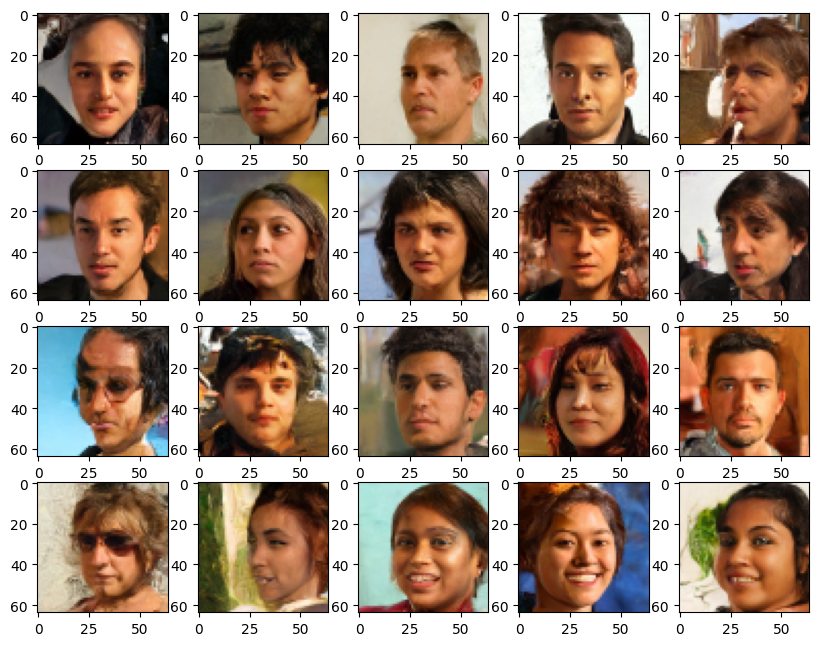

In [163]:
columns = 5
rows = 5
fig = plt.figure(figsize=(10, 10), dpi=100)
sample_ = sample.permute(0, 2, 3, 1) # BxHxWxC
for i in range(0, sample_.shape[0]):
    s_ = decolor(s=sample_[i], out_c=args.out_c)
    s_ = s_.detach().cpu().numpy()
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(s_)

plt.show()
